In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn import metrics


plt.figure(figsize=(20,10))
%matplotlib inline

import warnings
warnings.filterwarnings('ignore');

### Utility functions

In [54]:
def percentage_empty(df):
    return display_all(df.isnull().sum().sort_index()/len(df) *100)


def dependent_column_to_categorical(df,column):
    '''
    https://www.wine-searcher.com/wine-scores
    '''
    if (df[column] >= 80) & (df[column] <= 84):
        return "Good"
    elif (df[column] >= 85) & (df[column] <= 89):
        return "Very good"
    elif (df[column] >= 90) & (df[column] <= 94):
        return "Outstanding"
    elif (df[column] >= 95) & (df[column] <= 100):
        return "Classic"
    

def plot_var(df,feat):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.countplot(x=feat,data=df)
    return df.loc[:,feat].value_counts()

In [58]:
datatypes = {
    "Unnamed: 0":"int64",
    "country":"object",
    "description":"object",
    "designation":"object",
    "points":"int64",
    "price":"float64",
    "province":"object",
    "region_1":"object",
    "region_2":"object",
    "taster_name":"object",
    "taster_twitter_handle":"object",
    "title":"object",
    "variety":"object",
    "winery":"object"
}

In [59]:
df = pd.read_csv('../data_root/raw/wine_dataset.csv',dtype=datatypes)

## Exploratory Data Analysis

In [60]:
df.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Fragrances suggest hay, crushed tomato vine an...",Kirchleiten,90,30.0,Northeastern Italy,Alto Adige,NaN,Kerin O’Keefe,@kerinokeefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon,Tiefenbrunner
1,1,France,"Packed with fruit and crisp acidity, this is a...",NaN,87,22.0,Loire Valley,Sancerre,NaN,Roger Voss,@vossroger,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé,Bernard Reverdy et Fils
2,2,Italy,"This easy, ruby-red wine displays fresh berry ...",NaN,86,NaN,Tuscany,Chianti Classico,NaN,NaN,NaN,Dievole 2009 Chianti Classico,Sangiovese,Dievole


#### Number of unique Values in each column

In [27]:
df.nunique().sort_values(ascending=False)

Unnamed: 0               10000
description               9942
title                     9930
winery                    5460
designation               5381
region_1                   724
variety                    333
province                   248
price                      188
country                     37
points                      21
taster_name                 18
region_2                    17
taster_twitter_handle       14
dtype: int64

#### Number of nan values in each column

In [28]:
df.isna().sum().sort_values(ascending=False)

region_2                 6147
designation              2829
taster_twitter_handle    2356
taster_name              1985
region_1                 1664
price                     677
province                    6
country                     6
winery                      0
variety                     0
title                       0
points                      0
description                 0
Unnamed: 0                  0
dtype: int64

#### Percentage null

In [29]:
percentage_empty(df)

Unnamed: 0                0.00
country                   0.06
description               0.00
designation              28.29
points                    0.00
price                     6.77
province                  0.06
region_1                 16.64
region_2                 61.47
taster_name              19.85
taster_twitter_handle    23.56
title                     0.00
variety                   0.00
winery                    0.00
dtype: float64

#### Dropping some columns

<p>designation - 28.3% of its values are null. It has 2829 unique values. </p>
 
<p>province - has less than one value and 243 unique values</p>

<p>region_2 - It has more than 60% empty column field</p>

<p>region_1 - 724 unique values and 16% nan values</p>

<p>winery - 54% of the values here are unique</p>

<p>taster_name and taster_twitter_handle handle describe the same thing. However, There are more unique values in 
    taster_name column than taster_twitter_handle hence we'll drop taster_twitter_handle</p>


In [30]:
columns_to_drop = ['Unnamed: 0','region_2','designation','taster_twitter_handle','region_1','province','winery']

In [31]:
df.drop(columns_to_drop,axis=1,inplace=True)

In [32]:
df.head()

,country,description,points,price,taster_name,title,variety
0,Italy,"Fragrances suggest hay, crushed tomato vine an...",90,30.0,Kerin O’Keefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon
1,France,"Packed with fruit and crisp acidity, this is a...",87,22.0,Roger Voss,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé
2,Italy,"This easy, ruby-red wine displays fresh berry ...",86,NaN,NaN,Dievole 2009 Chianti Classico,Sangiovese
3,US,Pretty in violet and rose petals this is a low...,92,50.0,Virginie Boone,Davis Family 2012 Horseshoe Bend Vineyard Pino...,Pinot Noir
4,US,This golden wine confounds in a mix of wet sto...,93,38.0,Virginie Boone,Dutton-Goldfield 2013 Dutton Ranch Chardonnay ...,Chardonnay


## Some Questions to explore

#### 1.  Which wine variety gets the highest and lowest points averagely?

In [34]:
df_group_by_score = df['points'].groupby(df['variety'])

df_group_by_score.mean().sort_values(ascending=False)

wine_with_highest_points_on_average = df_group_by_score.mean().sort_values(ascending=False)[:10]

wine_with_lowest_points_on_average = df_group_by_score.mean().sort_values(ascending=True)[:10]

In [35]:
wine_with_highest_points_on_average

variety
Scheurebe               94.000000
Assyrtiko               93.000000
Bual                    93.000000
Trousseau Gris          93.000000
Austrian white blend    93.000000
Prugnolo Gentile        93.000000
Picolit                 92.750000
Alsace white blend      92.666667
Shiraz-Viognier         92.400000
Tinta Negra Mole        92.000000
Name: points, dtype: float64

In [36]:
wine_with_lowest_points_on_average

variety
Vignoles                   80.0
Chambourcin                80.0
Tempranillo Blanco         81.0
Tempranillo-Syrah          82.0
Macabeo-Chardonnay         83.0
Chelois                    83.0
Garnacha-Syrah             83.0
Sauvignon Blanc-Verdejo    83.0
Cabernet Franc-Merlot      83.0
Traminette                 83.0
Name: points, dtype: float64

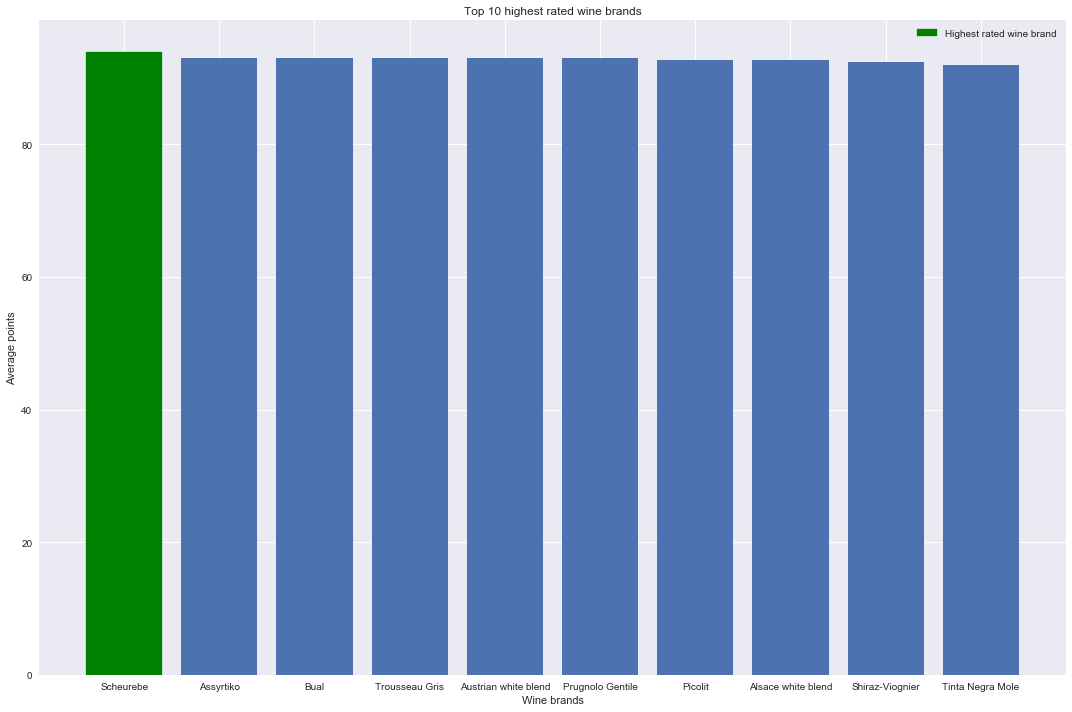

In [42]:
np.random.seed(42)

fig, ax = plt.subplots(figsize=(15, 10))
plt.style.use("seaborn")

x = list(wine_with_highest_points_on_average.to_dict().keys())

y = list(wine_with_highest_points_on_average.to_dict().values())
plot = plt.bar(x, y,label='Highest rated wine brand')
plot[0].set_color('g')

plt.legend()

plt.title("Top 10 highest rated wine brands")
plt.xlabel("Wine brands")
plt.ylabel("Average points")

plt.tight_layout()

plt.show()

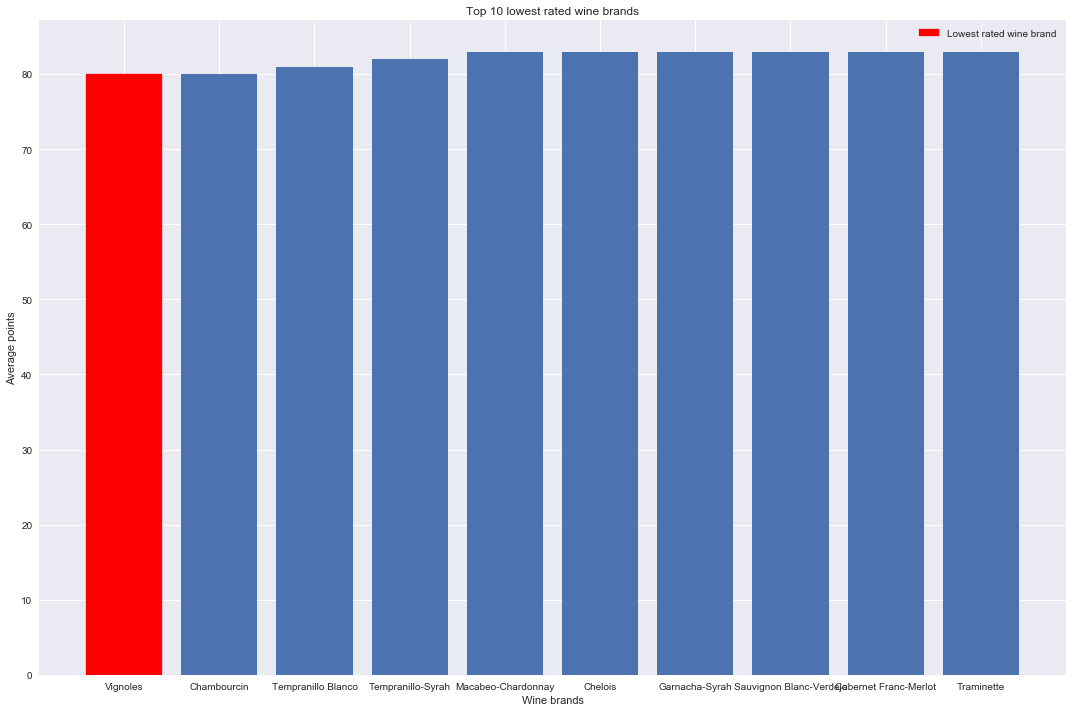

In [44]:
fig, ax = plt.subplots(figsize=(15,10))

plt.style.use("seaborn")

x = list(wine_with_lowest_points_on_average.to_dict().keys())

y = list(wine_with_lowest_points_on_average.to_dict().values())
plot = plt.bar(x, y,label='Lowest rated wine brand')
plot[0].set_color('r')

plt.legend()

plt.title("Top 10 lowest rated wine brands")
plt.xlabel("Wine brands")
plt.ylabel("Average points")

plt.tight_layout()

plt.show()

#### 2.  Which tasters gave the most generous points?

In [46]:
df_group_by_score = df['points'].groupby(df['taster_name'])

highest_tasters = df_group_by_score.mean().sort_values(ascending=False)
highest_tasters

taster_name
Anne Krebiehl MW      90.491525
Matt Kettmann         90.032468
Mike DeSimone         89.450000
Virginie Boone        89.222531
Paul Gregutt          89.148594
Kerin O’Keefe         88.890825
Roger Voss            88.754601
Jim Gordon            88.618462
Joe Czerwinski        88.575130
Sean P. Sullivan      88.567867
Anna Lee C. Iijima    88.352239
Jeff Jenssen          88.325581
Lauren Buzzeo         87.596154
Fiona Adams           87.000000
Susan Kostrzewa       86.850000
Michael Schachner     86.822020
Carrie Dykes          86.800000
Alexander Peartree    86.461538
Name: points, dtype: float64

#### 3.  What is the relationship between Prices of wine and points

In [48]:
df.head(1)

,country,description,points,price,taster_name,title,variety
0,Italy,"Fragrances suggest hay, crushed tomato vine an...",90,30.0,Kerin O’Keefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon


In [49]:
df_price_points_relationship = df[['price','points']]
df_price_points_relationship.isna().sum()

df_price_points_relationship.dropna(inplace=True)
df_price_points_relationship.shape

(9323, 2)

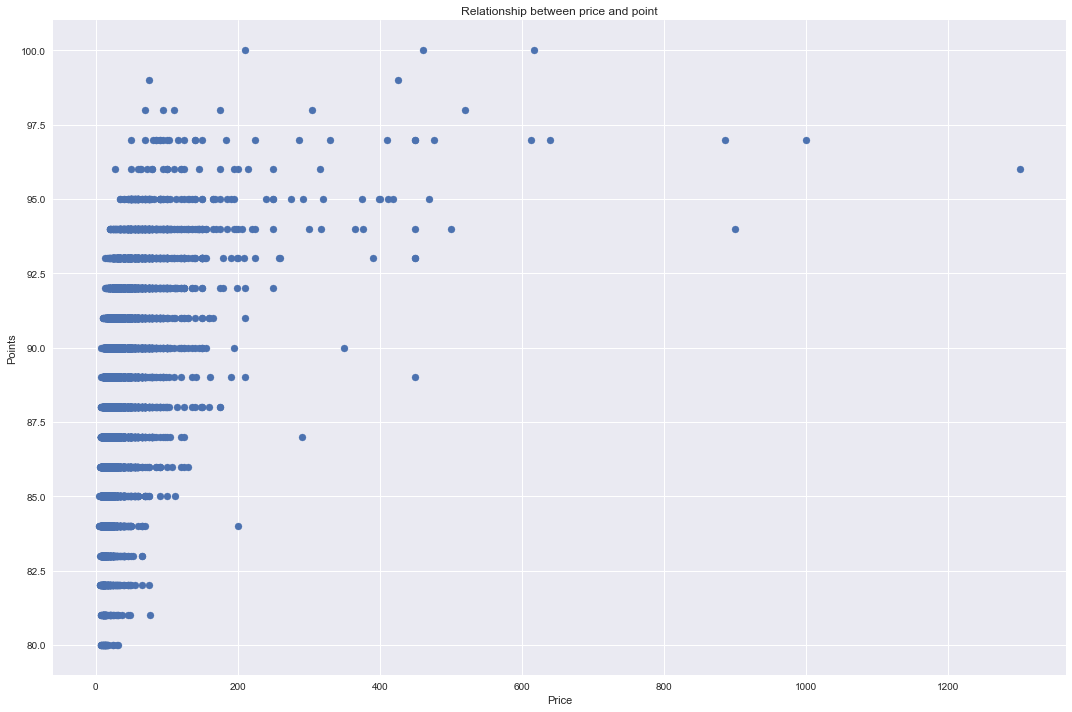

In [50]:
np.random.seed(42)
fig, ax = plt.subplots(figsize=(15,10))

plt.style.use("seaborn")

x = df_price_points_relationship['price']
y = df_price_points_relationship['points']


plt.scatter(x, y)

plt.title('Relationship between price and point')
plt.xlabel('Price')
plt.ylabel('Points')

plt.tight_layout()
plt.show()

<p>There is a high concentration low priced high point wine. The points doesn't necessarily depend on the price. There are low priced wine that has really high points. In fact,
wine with the highest points weren't the most pricy.</p>

### Distribution of values in dependent column

In [52]:
df["points"] = df.apply(lambda df:dependent_column_to_categorical(df,"points"),
                                      axis = 1)

Very good      5243
Outstanding    3626
Good            961
Classic         170
Name: points, dtype: int64

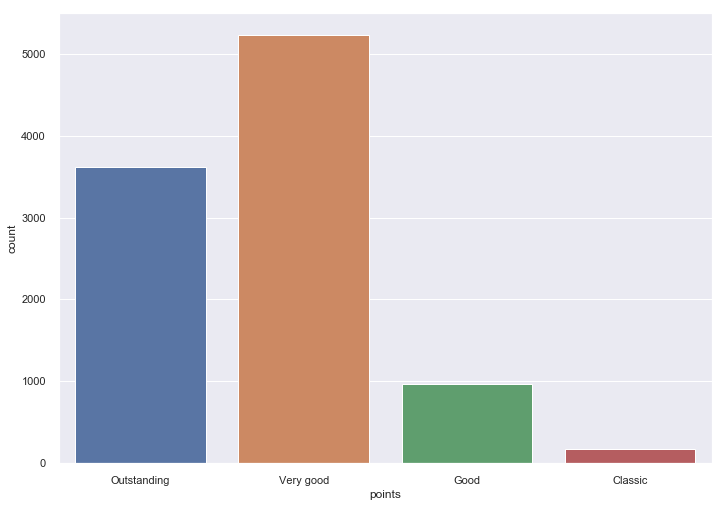

In [55]:
plot_var(df,feat='points')

<p>There is a huge imbalance between 'Very good','Good' and 'Classic'. I expect this to affect the predictability
of the algorithm</p>

<p>This can however be addressed using the <b>synthetic minority over sampling technique</b>. Check <a href="https://arxiv.org/pdf/1106.1813.pdf">here</a>